# 1. Text Classification with 5 classes approach


## 1.1 Text Preprocessing, Tokenization, and Sequence Padding:

### Load the dataset:

In [ ]:
# Install required packages
!pip install contractions
!pip install gensim
!pip install wordcloud
!pip install gradio
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import gradio as gr
import gensim.downloader as api
from imblearn.over_sampling import RandomOverSampler

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/AL and ML/Assignment II/Hotel_Reviews.csv')

In [ ]:
# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (20491, 2)

First 5 rows:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
np.sort(df['Rating'].unique())

array([1, 2, 3, 4, 5])

In [ ]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df['Rating'].value_counts()

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


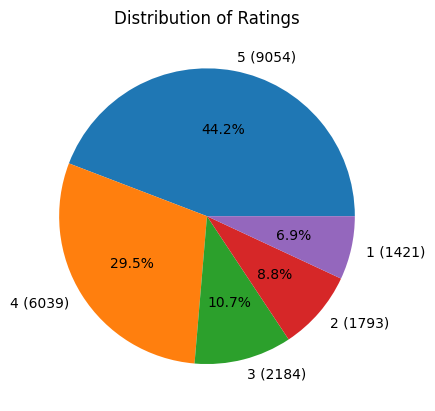

In [ ]:
rating_counts = df["Rating"].value_counts()

# Create a pie plot
plt.pie(rating_counts, labels=[f"{label} ({count})" for label, count in zip(rating_counts.index, rating_counts)], autopct='%1.1f%%')
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
#checking null value
df.isna().sum()

,0
Review,0
Rating,0


In [ ]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Find the maximum length of text in the 'Review' column
max_length = df['Review'].str.len().max()

# Print the maximum length
print(f"The maximum length of text in the 'Review' column is: {max_length}")


The maximum length of text in the 'Review' column is: 13501


In [ ]:
# any duplicate data
df.duplicated().sum()

0

### Data pre-processing

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Handle contractions
    text = contractions.fix(text)

    # Remove stopwords and lemmatize, retain sentiment stopwords
    tokens = text.split()
    sentiment_stopwords = {'not', 'very', 'really', 'quite', 'too', 'so', 'bad', 'poor', 'great', 'good', 'never', 'terrible', 'excellent', 'horrible', 'awful'}
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words or word in sentiment_stopwords]
    return ' '.join(tokens)

In [ ]:
# Preprocess the reviews
df['cleaned_review'] = df['Review'].apply(preprocess_text)

Generating word cloud for cleaned training data...


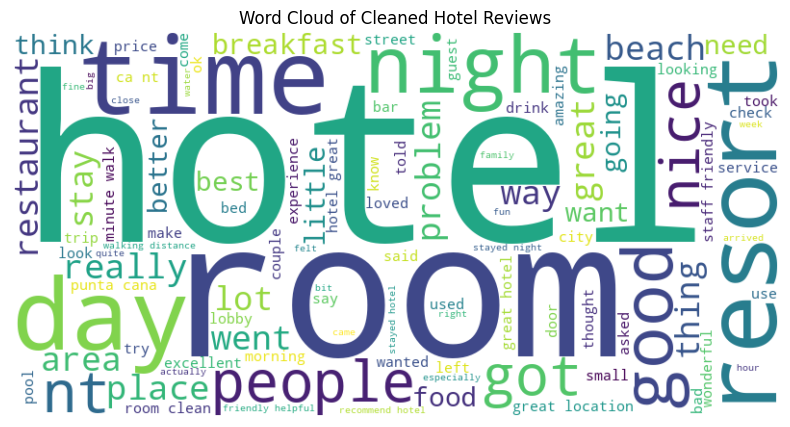

In [ ]:
# Plot most frequent words
print("Generating word cloud for cleaned training data...")
all_text = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, random_state=42).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Hotel Reviews')
plt.savefig('word_cloud.png')
plt.show()

Generating bar plot of most frequent words...


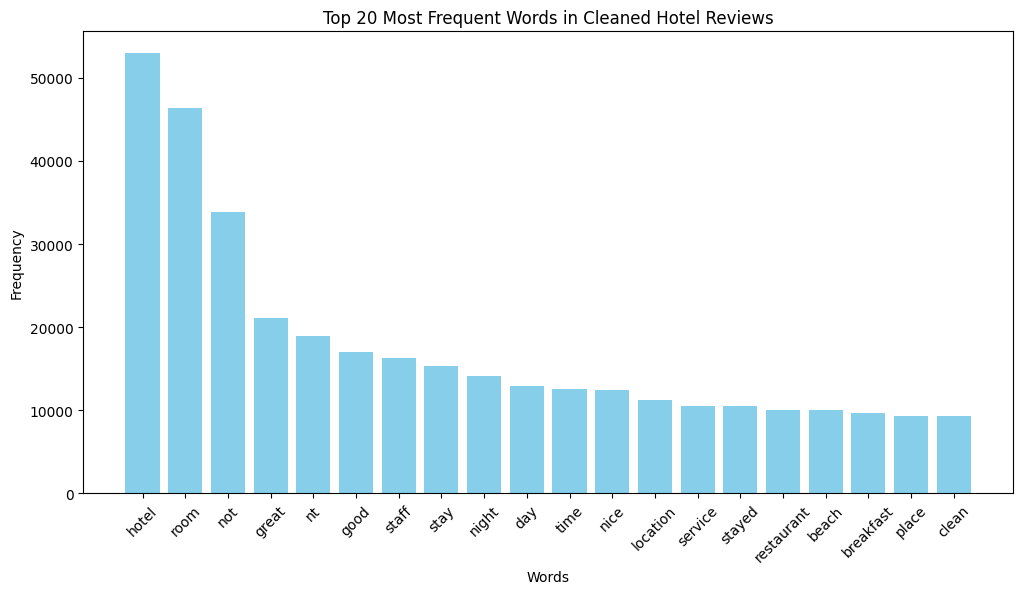

In [ ]:
# Top 20 most frequent words
print("Generating bar plot of most frequent words...")
words = all_text.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cleaned Hotel Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('frequent_words.png')
plt.show()

In [ ]:
df.head()

,Review,Rating,Length,cleaned_review
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,1689,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room not experience hotel monaco seattle ...
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay great stay went seahawk game awesom...


### Data split and oversampling

In [ ]:
# Split dataset
X = df['cleaned_review']
y = df['Rating'] - 1  # Adjust ratings to 0-4 for one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Oversample minority classes (ratings 1, 2, 3) on training data
ros = RandomOverSampler(sampling_strategy={0: 4000, 1: 4000, 2: 4000}, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)
X_train_resampled = X_train_resampled['cleaned_review']  # Convert back to Series

In [ ]:
# Check new training distribution
print("\nNew Training Distribution after Oversampling:")
print(pd.Series(y_train_resampled).value_counts())


New Training Distribution after Oversampling:
Rating
4    7243
3    4831
1    4000
2    4000
0    4000
Name: count, dtype: int64


### Tokenize text

In [ ]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_resampled)  # Fit on resampled training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_resampled)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate 95th percentile length for padding
train_seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(train_seq_lengths, 95))
print(f"Using sequence length of {max_len} (95th percentile)")

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert labels to one-hot encoding
num_classes = 5
y_train_one_hot = tf.keras.utils.to_categorical(y_train_resampled, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

Using sequence length of 274 (95th percentile)


In [ ]:
# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
# Adjust weights
class_weight_dict[0] *= 0.8
class_weight_dict[1] *= 0.8
class_weight_dict[2] *= 0.8
print("\nAdjusted Class Weights:", class_weight_dict)


Adjusted Class Weights: {0: 2.3067018469656992, 1: 1.8289539748953976, 2: 1.5012707498568976, 3: 0.6786172635065204, 4: 0.45263012563854754}


## 1.2 Model Building and Training

### Build Model

In [ ]:
# Load pretrained Word2Vec embeddings for Model 3
print("Loading Word2Vec embeddings...")

embedding_model = api.load('word2vec-google-news-300')
embedding_dim = 300

Loading Word2Vec embeddings...


In [ ]:
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [ ]:
# Model 1: Bidirectional SimpleRNN
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model1.compile(optimizer=Adam(learning_rate=0.0003, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model 2: Bidirectional LSTM
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model2.compile(optimizer=Adam(learning_rate=0.0003, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model 3: Bidirectional LSTM with Word2Vec
model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model3.compile(optimizer=Adam(learning_rate=0.00005, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 1.3 Model Training and Evaluation

### Train Model

In [ ]:
# Training function
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=20):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_plot.png')
    plt.show()

    return history

Training Model 1 (SimpleRNN)...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.3896 - loss: 2.1341 - val_accuracy: 0.5636 - val_loss: 1.1906 - learning_rate: 3.0000e-04
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.6255 - loss: 1.1086 - val_accuracy: 0.5772 - val_loss: 1.0383 - learning_rate: 3.0000e-04
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.7410 - loss: 0.7841 - val_accuracy: 0.5867 - val_loss: 1.0257 - learning_rate: 3.0000e-04
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.8083 - loss: 0.5881 - val_accuracy: 0.5938 - val_loss: 1.0490 - learning_rate: 3.0000e-04
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.8480 - loss: 0.4737 - val_accuracy: 0.5889 - val_loss: 1.0995 - learning_rate: 3.0000e-04
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8749 - loss: 0.3954 - val_accuracy: 0.5811 - val_loss: 1.1294 - learning_rate: 1.5000e-04


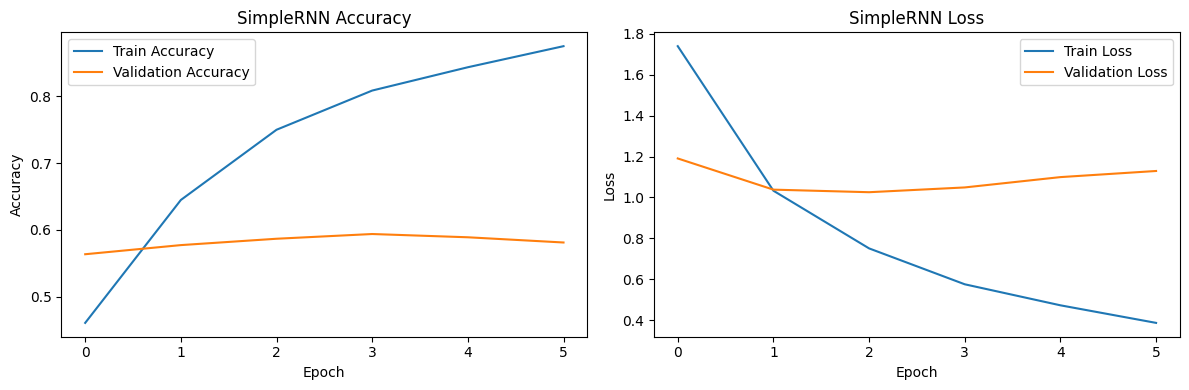

In [ ]:
# Train models
print("Training Model 1 (SimpleRNN)...")
history1 = train_model(model1, X_train_padded, y_train_one_hot, X_test_padded, y_test_one_hot, "SimpleRNN")



Training Model 2 (LSTM)...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.3778 - loss: 2.8467 - val_accuracy: 0.5877 - val_loss: 0.9976 - learning_rate: 3.0000e-04
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.5992 - loss: 0.9903 - val_accuracy: 0.5889 - val_loss: 0.9566 - learning_rate: 3.0000e-04
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.6898 - loss: 0.8224 - val_accuracy: 0.5758 - val_loss: 0.9830 - learning_rate: 3.0000e-04
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7420 - loss: 0.7141 - val_accuracy: 0.5911 - val_loss: 1.0180 - learning_rate: 3.0000e-04
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7860 - loss: 0.6295 - val_accuracy: 0.5975 - val_loss: 1.0618 - learning_rate: 1.5000e-04


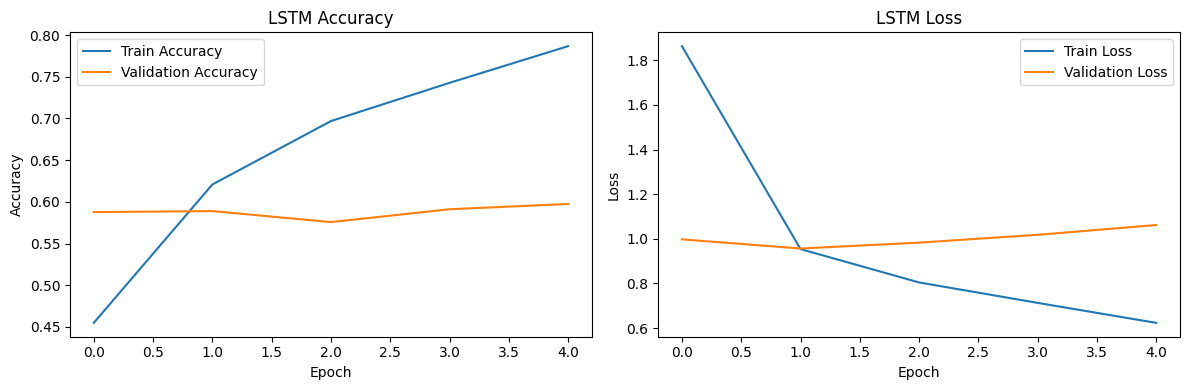

In [ ]:
print("\nTraining Model 2 (LSTM)...")
history2 = train_model(model2, X_train_padded, y_train_one_hot, X_test_padded, y_test_one_hot, "LSTM")


Training Model 3 (LSTM with Word2Vec)...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.2838 - loss: 8.1081 - val_accuracy: 0.4904 - val_loss: 4.4666 - learning_rate: 5.0000e-05
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.4618 - loss: 3.9471 - val_accuracy: 0.5540 - val_loss: 2.5373 - learning_rate: 5.0000e-05
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5100 - loss: 2.3703 - val_accuracy: 0.5631 - val_loss: 1.7478 - learning_rate: 5.0000e-05
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.5546 - loss: 1.6791 - val_accuracy: 0.5909 - val_loss: 1.4116 - learning_rate: 5.0000e-05
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.5771 - loss: 1.3893 - val_accuracy: 0.5914 - val_loss: 1.2858 - learning_rate: 5.0000e-05
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.6190 - loss: 1.2310 - val_accuracy: 0.5962 - val_loss: 1.2242 - learning_rate: 5.0000e-05
Epoch 7/20

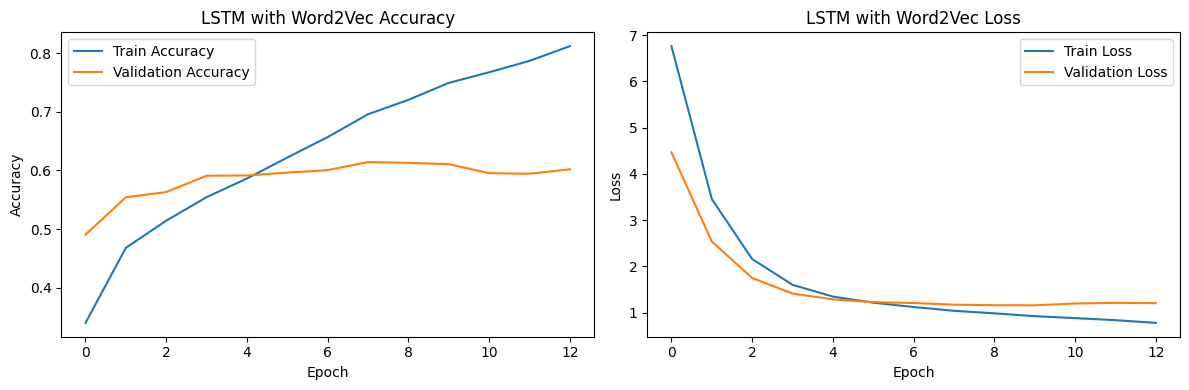

In [ ]:
print("\nTraining Model 3 (LSTM with Word2Vec)...")
history3 = train_model(model3, X_train_padded, y_train_one_hot, X_test_padded, y_test_one_hot, "LSTM with Word2Vec")

### Evaluate Model

In [ ]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=['1', '2', '3', '4', '5']))

    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    return acc

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

SimpleRNN Evaluation:
Accuracy: 0.5867284703586241

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.73      0.62       284
           2       0.42      0.36      0.39       359
           3       0.30      0.26      0.28       437
           4       0.56      0.26      0.36      1208
           5       0.66      0.91      0.77      1811

    accuracy                           0.59      4099
   macro avg       0.50      0.50      0.48      4099
weighted avg       0.56      0.59      0.55      4099



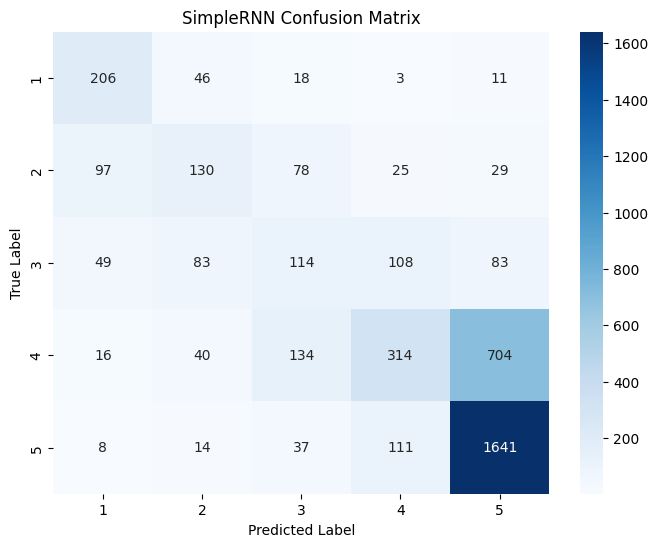

In [ ]:
acc1 = evaluate_model(model1, X_test_padded, y_test_one_hot, "SimpleRNN")

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

LSTM Evaluation:
Accuracy: 0.5889241278360575

Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.71      0.65       284
           2       0.42      0.41      0.42       359
           3       0.31      0.42      0.36       437
           4       0.51      0.35      0.42      1208
           5       0.73      0.81      0.76      1811

    accuracy                           0.59      4099
   macro avg       0.52      0.54      0.52      4099
weighted avg       0.58      0.59      0.58      4099



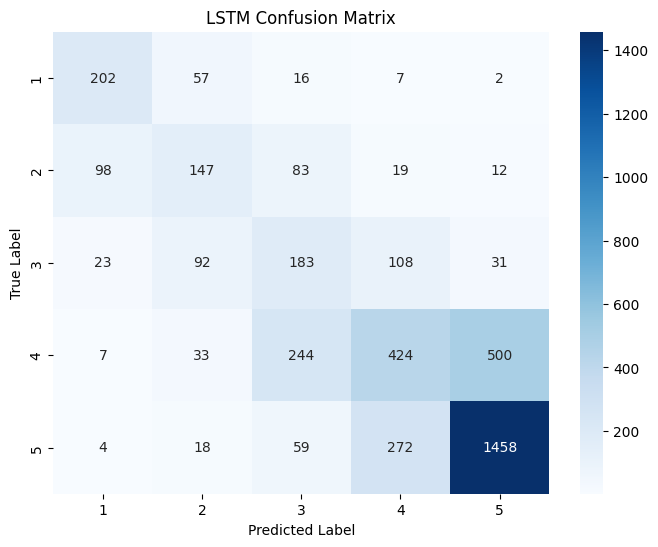

In [ ]:
acc2 = evaluate_model(model2, X_test_padded, y_test_one_hot, "LSTM")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

LSTM with Word2Vec Evaluation:
Accuracy: 0.6106367406684557

Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.64      0.66       284
           2       0.45      0.43      0.44       359
           3       0.36      0.40      0.38       437
           4       0.52      0.46      0.49      1208
           5       0.74      0.79      0.77      1811

    accuracy                           0.61      4099
   macro avg       0.55      0.55      0.55      4099
weighted avg       0.61      0.61      0.61      4099



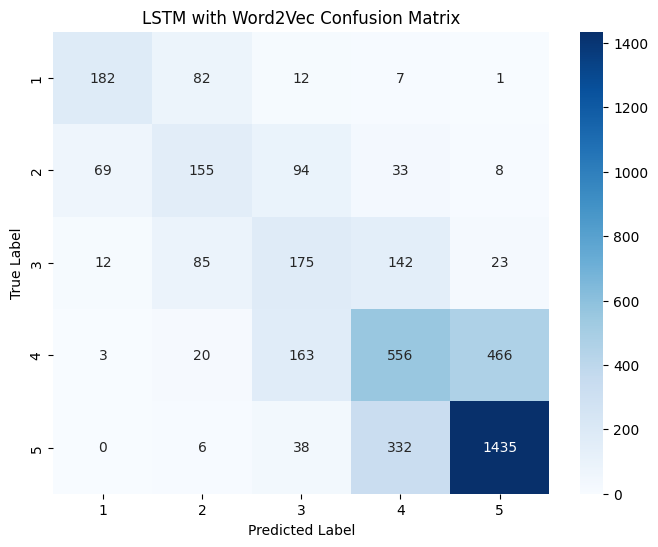

In [ ]:
acc3 = evaluate_model(model3, X_test_padded, y_test_one_hot, "LSTM with Word2Vec")

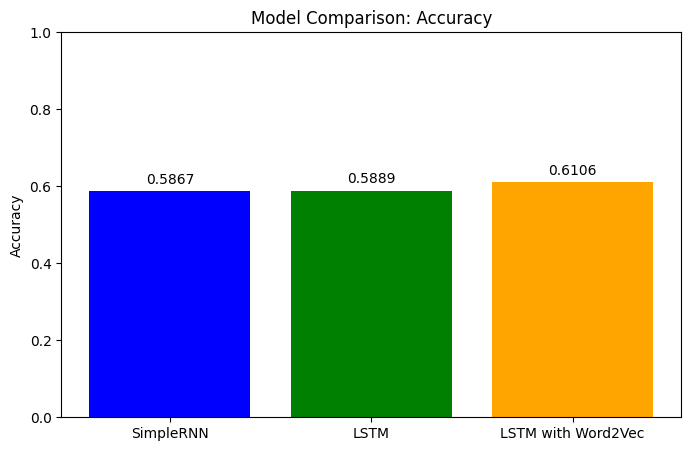

In [ ]:
# Compare model performances
plt.figure(figsize=(8, 5))
plt.bar(['SimpleRNN', 'LSTM', 'LSTM with Word2Vec'], [acc1, acc2, acc3], color=['blue', 'green', 'orange'])
plt.title('Model Comparison: Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([acc1, acc2, acc3]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.savefig('model_comparison.png')
plt.show()

## 1.4 GUI for Real Time Prediction:

In [ ]:
# Gradio GUI for Real-Time Prediction
def predict_rating(review, model_name):
    if not review.strip():
        return "Please enter a review."

    cleaned_review = preprocess_text(review)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    model_dict = {
        "SimpleRNN": model1,
        "LSTM": model2,
        "LSTM with Word2Vec": model3
    }

    if model_name not in model_dict:
        return "Invalid model selected."

    model = model_dict[model_name]
    prediction = model.predict(padded_sequence, verbose=0)[0]
    predicted_class = np.argmax(prediction) + 1
    confidence = np.max(prediction)

    return f"Predicted Rating: {predicted_class}\nConfidence: {confidence:.4f}"

In [ ]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Hotel Review Rating Prediction")
    gr.Markdown("Enter a hotel review and select a model to predict the rating (1-5).")

    with gr.Row():
        review_input = gr.Textbox(label="Hotel Review", placeholder="e.g., The hotel was amazing!", lines=3)
    with gr.Row():
        model_choice = gr.Dropdown(choices=["SimpleRNN", "LSTM", "LSTM with Word2Vec"], label="Select Model", value="LSTM with Word2Vec")

    predict_button = gr.Button("Predict Rating")
    output = gr.Textbox(label="Prediction Result", placeholder="Prediction will appear here...")

    predict_button.click(fn=predict_rating, inputs=[review_input, model_choice], outputs=output)

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://66f2f6d542fb2bbe9e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 2. Text Classification with two classes approach

In [ ]:
!pip install --upgrade \
  pandas \
  numpy \
  matplotlib \
  seaborn \
  wordcloud \
  scikit-learn \
  tensorflow \
  keras \
  gensim \
  nltk \
  contractions \
  gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import os
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import gradio as gr

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# GloVe embeddings
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import gensim.downloader as api

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Load & Clean Data
df = pd.read_csv('/content/drive/MyDrive/AL and ML/Hotel_Reviews.csv')[['Review', 'Rating']].dropna()
print("Rating Distribution:\n", df['Rating'].value_counts().sort_index())

Rating Distribution:
 Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64


In [ ]:
# Convert ratings to binary sentiment (1-2: bad(0), 4-5: good(1), remove 3)
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x <= 2 else 1)

In [ ]:
# Check class distribution
print("Class Distribution:")
print(df['Sentiment'].value_counts())

Class Distribution:
Sentiment
1    15093
0     3214
Name: count, dtype: int64


In [ ]:
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
5,love monaco staff husband stayed hotel crazy w...,5,1


In [ ]:
df.isnull().any()

,0
Review,False
Rating,False
Sentiment,False


In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [ ]:
# Split into train and test
X = df['Review']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Clean text
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

Generating word cloud for cleaned training data...


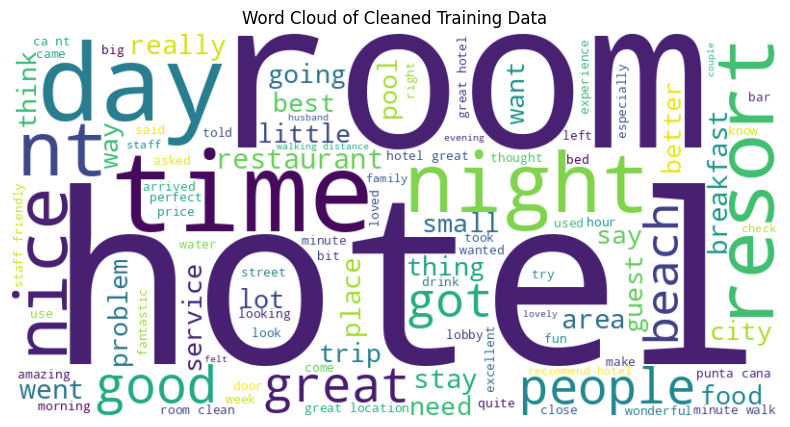

In [ ]:
print("Generating word cloud for cleaned training data...")
all_text = ' '.join(X_train_clean)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, random_state=42).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Training Data')
plt.show()

Generating bar plot of most frequent words...


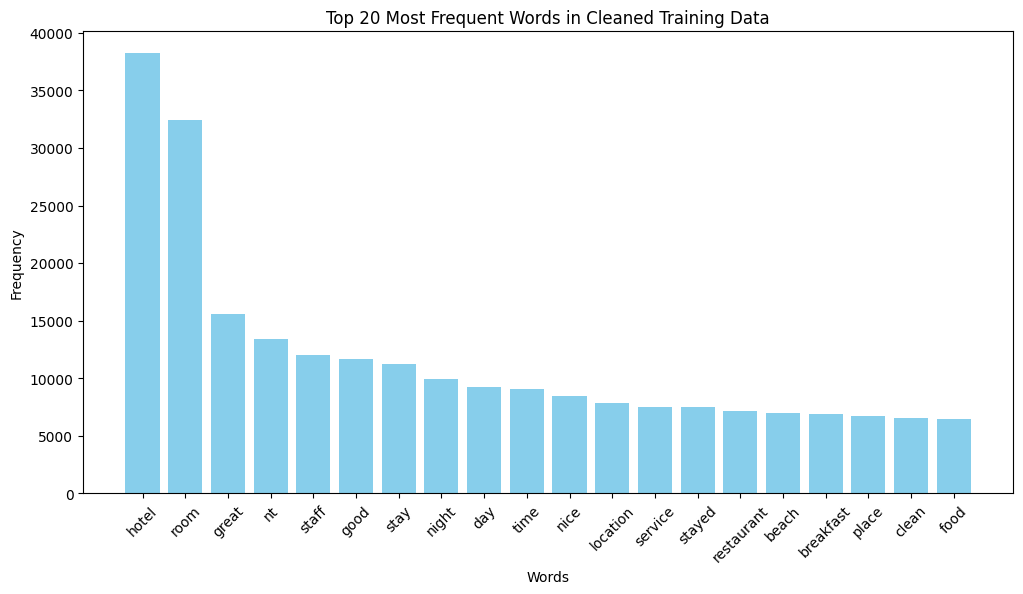

In [ ]:
print("Generating bar plot of most frequent words...")
words = all_text.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cleaned Training Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_clean)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Calculate sequence lengths to determine padding length (95th percentile)
train_seq_lengths = [len(seq) for seq in X_train_seq]
percentile_95 = np.percentile(train_seq_lengths, 95)
max_len = int(percentile_95)
print(f"Using sequence length of {max_len} (95th percentile)")

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Validate data shapes
print(f"X_train_pad shape: {X_train_pad.shape}, y_train shape: {y_train.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}, y_test shape: {y_test.shape}")
print("Test class distribution:", np.unique(y_test, return_counts=True))

Using sequence length of 254 (95th percentile)
X_train_pad shape: (14645, 254), y_train shape: (14645,)
X_test_pad shape: (3662, 254), y_test shape: (3662,)
Test class distribution: (array([0, 1]), array([ 643, 3019]))


In [ ]:
# Apply SMOTE to the padded sequences
print("\nBefore SMOTE class distribution:", np.unique(y_train, return_counts=True))


Before SMOTE class distribution: (array([0, 1]), array([ 2571, 12074]))


In [ ]:
# Reshape for SMOTE (temporarily flatten the sequences)
n_samples, n_timesteps = X_train_pad.shape
X_train_flat = X_train_pad.reshape(n_samples, -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape back to original dimensions
X_train_resampled = X_train_resampled_flat.reshape(-1, n_timesteps)

print("After SMOTE class distribution:", np.unique(y_train_resampled, return_counts=True))

After SMOTE class distribution: (array([0, 1]), array([12074, 12074]))


In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 1.0}


In [ ]:
# Model 1: Simple RNN
embedding_dim = 128

# Model 1: Simple RNN (Trainable Embedding)
model1 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model 2: LSTM (Trainable Embedding)
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=30):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    try:
        print(f"Training {model_name} with input shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_val={X_val.shape}, y_val={y_val.shape}")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return history
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        return None

Training Model 1 (SimpleRNN)...
Training SimpleRNN with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5937 - loss: 0.6744 - val_accuracy: 0.1942 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5354 - loss: 0.6870 - val_accuracy: 0.7430 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7368 - loss: 0.5626 - val_accuracy: 0.7652 - val_loss: 0.5266 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8206 - loss: 0.4575 - val_accuracy: 0.6578 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8090 - loss: 0.4652 - val_accuracy: 0.7944 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8423 - loss: 0.4102 - va

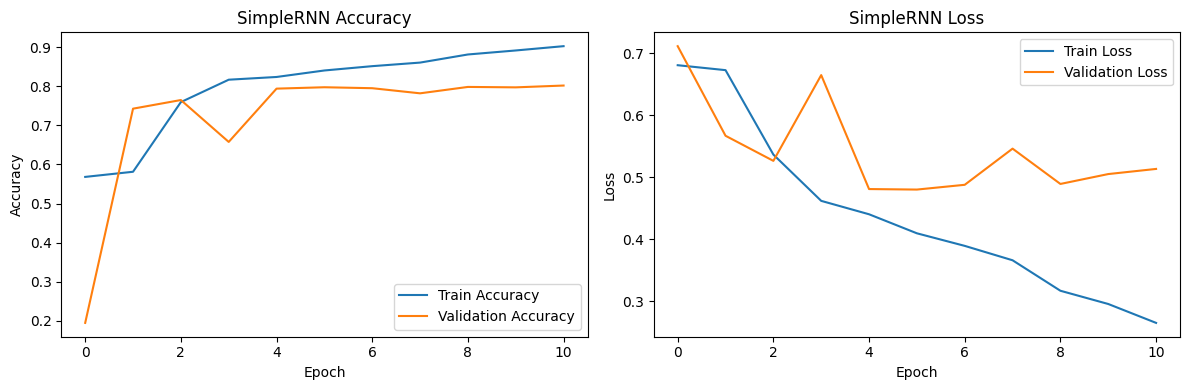

In [ ]:
# Train models
print("Training Model 1 (SimpleRNN)...")
history1 = train_model(model1, X_train_resampled, y_train_resampled, X_test_pad, y_test, "SimpleRNN")


Training Model 2 (LSTM)...
Training LSTM with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5001 - loss: 0.6939 - val_accuracy: 0.7941 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5049 - loss: 0.6942 - val_accuracy: 0.8105 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5310 - loss: 0.6836 - val_accuracy: 0.7758 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8735 - loss: 0.3441 - val_accuracy: 0.8646 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9325 - loss: 0.2103 - val_accuracy: 0.9044 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9699 - loss: 0.1059 - val_accu

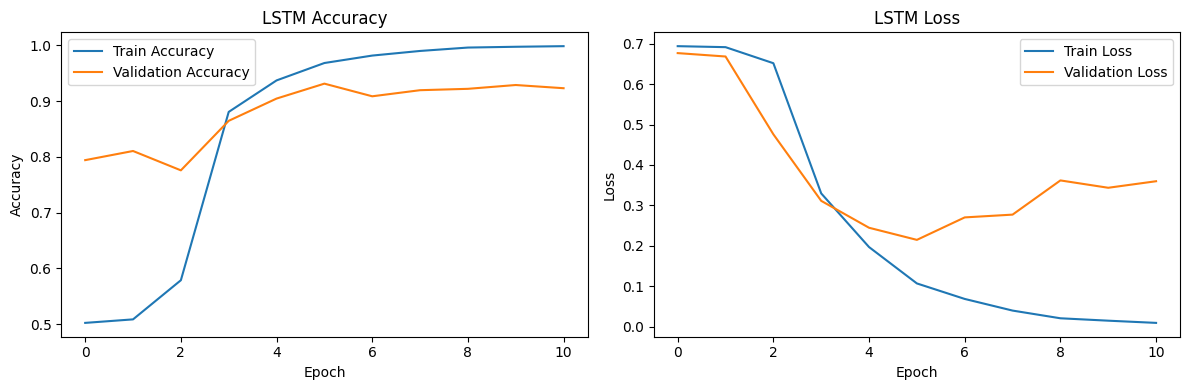

In [ ]:
print("\nTraining Model 2 (LSTM)...")
history2 = train_model(model2, X_train_resampled, y_train_resampled, X_test_pad, y_test, "LSTM")

In [ ]:
# Load Pre-trained GloVe Embeddings (300-dimensional) for Model 3
print("Loading GloVe embeddings for Model 3...")
try:
    embedding_model = api.load('glove-wiki-gigaword-300')
    embedding_dim = 300
except Exception as e:
    print(f"Error loading GloVe embeddings: {str(e)}")
    exit()

Loading GloVe embeddings for Model 3...


In [ ]:
#  Create embedding matrix for Model 3
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [ ]:
# Model 3: LSTM with GloVe Embeddings
model3 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Model 3 (LSTM with GloVe)...
Training LSTM with GloVe with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5094 - loss: 0.6920 - val_accuracy: 0.8037 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5150 - loss: 0.6894 - val_accuracy: 0.8184 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5612 - loss: 0.6561 - val_accuracy: 0.8727 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8935 - loss: 0.3294 - val_accuracy: 0.8935 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9492 - loss: 0.1822 - val_accuracy: 0.8979 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9662 - loss

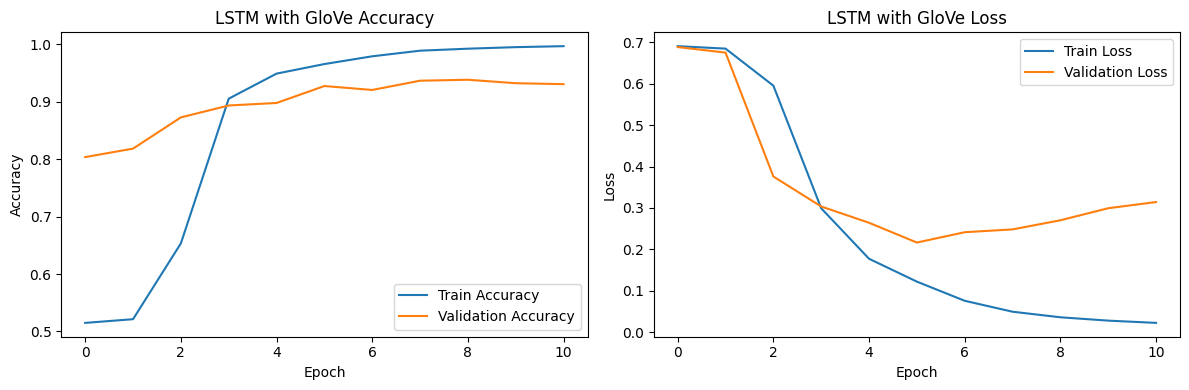

In [ ]:
print("\nTraining Model 3 (LSTM with GloVe)...")
history3 = train_model(model3, X_train_resampled, y_train_resampled, X_test_pad, y_test, "LSTM with GloVe")

In [ ]:
#  Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n{model_name} Evaluation:")
    acc = accuracy_score(y_test, y_pred) # Calculate accuracy
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return acc # Return the accuracy

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

SimpleRNN Evaluation:
Accuracy: 0.7979246313489896

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.76      0.57       643
           1       0.94      0.81      0.87      3019

    accuracy                           0.80      3662
   macro avg       0.70      0.78      0.72      3662
weighted avg       0.86      0.80      0.82      3662



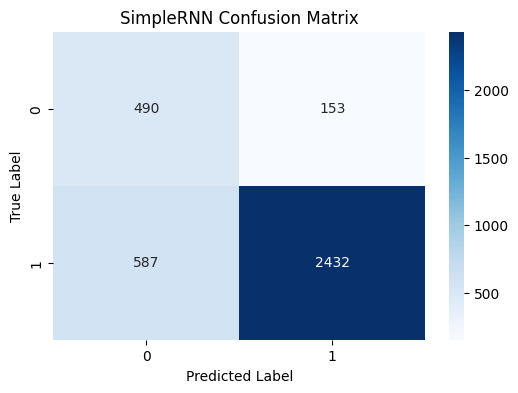

In [ ]:
# Evaluate models and collect accuracies
acc1 = evaluate_model(model1, X_test_pad, y_test, "SimpleRNN")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

LSTM Evaluation:
Accuracy: 0.931185144729656

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.79       643
           1       0.95      0.97      0.96      3019

    accuracy                           0.93      3662
   macro avg       0.89      0.86      0.88      3662
weighted avg       0.93      0.93      0.93      3662



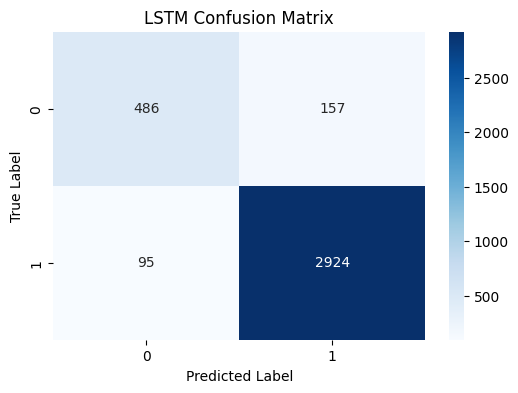

In [ ]:
acc2 = evaluate_model(model2, X_test_pad, y_test, "LSTM")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM with GloVe Evaluation:
Accuracy: 0.9273620972146368

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       643
           1       0.96      0.95      0.96      3019

    accuracy                           0.93      3662
   macro avg       0.87      0.89      0.88      3662
weighted avg       0.93      0.93      0.93      3662



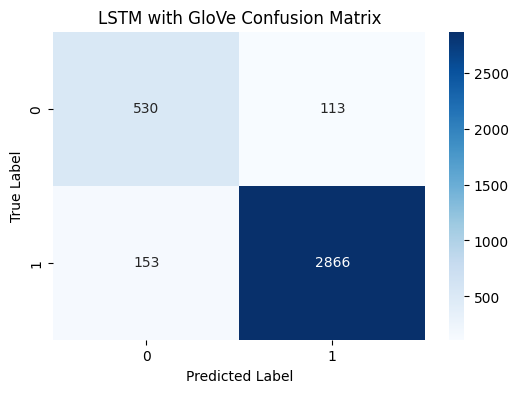

In [ ]:
acc3 = evaluate_model(model3, X_test_pad, y_test, "LSTM with GloVe")


Accuracies: {'SimpleRNN': 0.7979246313489896, 'LSTM': 0.931185144729656, 'LSTM with GloVe': 0.9273620972146368}


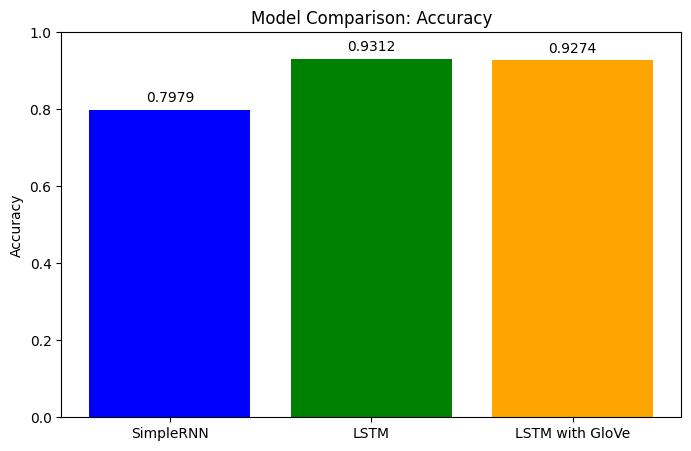

In [ ]:
# Debug: Print accuracies to check for None values
print("\nAccuracies:", {"SimpleRNN": acc1, "LSTM": acc2, "LSTM with GloVe": acc3})

# Compare model performances
models = ['SimpleRNN', 'LSTM', 'LSTM with GloVe']
accuracies = [acc1, acc2, acc3]

# Handle None values in accuracies
valid_accuracies = [acc if acc is not None else 0.0 for acc in accuracies]
valid_models = [m for m, acc in zip(models, accuracies) if acc is not None]

if not valid_accuracies:
    print("Error: No valid accuracies to plot. Check model training and evaluation.")
else:
    plt.figure(figsize=(8, 5))
    plt.bar(valid_models, valid_accuracies, color=['blue', 'green', 'orange'])
    plt.title('Model Comparison: Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(valid_accuracies):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.show()

In [ ]:
# Prediction function
def predict_sentiment(review, model_name):
    if not review.strip():
        return "Please enter a review."

    # Clean and preprocess the input review
    cleaned_review = clean_text(review)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Select model
    model_dict = {
        "SimpleRNN": model1,
        "LSTM": model2,
        "LSTM with GloVe": model3
    }

    if model_name not in model_dict:
        return "Invalid model selected."

    model = model_dict[model_name]

    # Predict
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return f"Sentiment: {sentiment}\nConfidence: {confidence:.4f}"

In [ ]:
# Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Hotel Review Sentiment Prediction")
    gr.Markdown("Enter a hotel review and select a model to predict whether the sentiment is Positive or Negative.")

    with gr.Row():
        review_input = gr.Textbox(
            label="Hotel Review",
            placeholder="e.g., The hotel was amazing with great service!",
            lines=3
        )

    with gr.Row():
        model_choice = gr.Dropdown(
            choices=["SimpleRNN", "LSTM", "LSTM with GloVe"],
            label="Select Model",
            value="LSTM"
        )

    predict_button = gr.Button("Predict Sentiment")
    output = gr.Textbox(label="Prediction Result", placeholder="Prediction will appear here...")

    predict_button.click(
        fn=predict_sentiment,
        inputs=[review_input, model_choice],
        outputs=output
    )

In [ ]:
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e6306a049046e3c06.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
